In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import itertools
import math
import statistics as sts
import gc as gc
import sys
from sklearn import preprocessing


## Aprovechamos los .hdf generados a partir de los .mat en el tp anterior.
path = "../../tp2/datos/"
load_path = path + "/{}.hdf"

##Electrodos de interes
electrodos = [8, 44, 80, 131, 185]

# Cantidad de pacientes S y P
N_P = 10
N_S = 10

<h1>Script Generador de Features</h1>
<blockquote>
    <p>Este script genera los features que luego utilizaremos en el análisis univariado y multivariado.</p>
    <p>Estas son:
    <ul>
        <li>Potencia para cada banda de frecuencia (Delta, Theta, Alpha, Beta y Gamma)</li>
        <li>Potencia normalizada para las mismas bandas de frecuencia.</li>
        <li>Una medida de información intra-electrodo</li>
        <li>Una medida de información inter-electrodo</li>
    </ul>
    </p>
    <p>Cada marcador se computa por cada epochs y luego se toma la media y el desvío estándard entre los valores de cada epochs. En el caso de los features espectrales, para el cómputo de un epoch primero se promedian las frecuencias entre los mismos electrodos utilizados en el TP2.</p>
    <p>Como medida intra-electrodo se decide utilizar la fuente de información modelada en el TP2 considerando sólo al electrodo 8. Se decide esto porque en los resultados observados presentó una mejor diferencia en los rangos de entropía para entre los pacientes P y S.</p>
    <p>La medida inter-electrodo es la entropía de la fuente modelada con un alfabeto general para todos los electrodos (lo mismo que se utilizó en el [TP2](https://github.com/BrianBohe/DataScienceCourse/tree/master/tp2).</p>
</blockquote>

<h4>Construyendo alfabetos</h4>
<blockquote>
<p>Primero vamos a generar al igual que en el TP anterior los alfabetos que se utilzarán luego en las medidas inter/intra-electrodo.</p>
</blockquote>

In [2]:
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)

pd_pacientes = pd.concat(pacientes_P + pacientes_S)

In [3]:
pacientes_b_mean = []
N_b = 0
step_b = 0
alfabeto_8 = []

# Calculo de N (cantidad de bins): Se usa n = 201 porque los epochs tienen esa cantidad de muestras
def calculo_N(df_):
    return math.ceil((df_.max() - df_.min()) / (3.5*df_.std() * 201 ** (-1/3)))

def calcular_simbolos_sensor_8_para_promediando_entre_pacientes(pacientes):
    pacientes_8 = pacientes.loc[pd.IndexSlice[:,:,8,:],:]
    val = pacientes_8.groupby(["epoch"])['valores'].mean()
    i_s = pd.DataFrame({'sensor':[8]})
    i_s['N'] = calculo_N(val)
    i_s['min'] = val.min()
    i_s['max'] = val.max()
    i_s['step'] = (i_s['max'] - i_s['min']) / i_s['N']
    return i_s

# Calcular N para hacer la transformación simbólica
def calcular_simbolos_inter_promediando_entre_pacientes(pacientes):
    pacientes_b_mean = pd.concat(pacientes_P + pacientes_S).groupby(["sensor","tiempo"]).mean()
    N_b = math.ceil(pacientes_b_mean.max() - pacientes_b_mean.min() / (pacientes_b_mean.std() * len(pacientes_b_mean) ** (-1/3)))
    step_b = (pacientes_b_mean.max() - pacientes_b_mean.min()) / N_b
    return pacientes_b_mean, N_b, step_b

def calcular_entropia_inter_electrodo_para_un_epoch(df_):
    df_['simbolos_inter'] = (df_["valores"] - pacientes_b_mean['valores'].min()) // step_b['valores']
    df_[df_['simbolos_inter'] < 0] = 0
    df_[df_['simbolos_inter'] > N_b] = N_b
    df_['repeticiones_inter'] = df_.groupby(["simbolos_inter"]).transform('count')['valores']
    df_['probabilidad_inter'] = df_['repeticiones_inter'] / len(df_)
    p = df_["probabilidad_inter"]
    return -sum(p * np.log(p))
    
def calcular_entropia_para_un_epoch(df_):
    df_['simbolos_intra'] = (df_['valores'].values - alfabeto_8['min'].values) // alfabeto_8['step'].values
    df_[df_['simbolos_intra'] < 0] = 0
    df_[df_['simbolos_intra'] > alfabeto_8['N'].values[0]] = alfabeto_8['N'].values[0]
    df_['repeticiones_intra'] = df_.groupby(["simbolos_intra"]).transform('count')['valores']
    df_['probabilidad_intra'] = df_['repeticiones_intra'] / len(df_)
    df_ = df_.groupby("simbolos_intra").first()
    p = df_["probabilidad_intra"]
    return -sum(p * np.log(p))

# Se calcula la cantidad de Bins promediando entre todos los pacientes
alfabeto_8 = calcular_simbolos_sensor_8_para_promediando_entre_pacientes(pd_pacientes)

# Para el caso de la medida inter-electrodo se calcula la cantidad de Bins entre todos los electrodos y pacientes 
pacientes_b_mean, N_b, step_b = calcular_simbolos_inter_promediando_entre_pacientes(pd_pacientes)

In [27]:
## Establecimos este orden para los features
def give_expected_ordered_keys():
    ordered_keys = []
    for i, forma_de_calcular_feature in enumerate(['media_','std_']):
        for  j, tipo_de_banda in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma', 'delta_norm', 'theta_norm', 'alpha_norm', 'beta_norm', 'gamma_norm', 'intra', 'inter']):
            ordered_keys.append("{}{}".format(forma_de_calcular_feature,tipo_de_banda))
    return np.array(ordered_keys)

##  Y así será al forma de los archivos pickle generados con los features (en crudo y normalizadas)
def numpy_to_pickle(aCollectionOfNumpyArray, aPickelFileName):
    print("Creando index...")
    lenght = int(len(aCollectionOfNumpyArray)/2)
    arrays_index = [
        ['P']*N_P+['S']*N_S,
        [i for j in range(2) for i in range(lenght)]
    ]

    index = pd.MultiIndex.from_arrays(arrays_index, names=["tipo", "indice_paciente"])
    arrays_columns = [
        ['media']*12+['std']*12,
        ['delta', 'theta', 'alpha', 'beta', 'gamma', 'delta_norm', 'theta_norm', 'alpha_norm', 'beta_norm', 'gamma_norm', 'intra', 'inter']*2
    ]

    index_columns = pd.MultiIndex.from_arrays(arrays_columns, names=["agrupacion_feature","feature"])

    df = pd.DataFrame(data=aCollectionOfNumpyArray, index=index, columns=index_columns)

    print(df)

    df.to_pickle("../data_set/{}.pickle".format(aPickelFileName))

In [5]:
##Definimos el orden de los atributos antes de codear de forma rapida
##Esta clase esta solo para asegurar ese orden.
class Sample():

    def __init__(self, featuresDict):
        self.features = {}

        for k,v in featuresDict.items():
            self.features[k] = v
                
    def show_features_as_np(self):
        valores = []
        for key in give_expected_ordered_keys():
            valores.append(self.features["{}".format(key)])
        
        return np.array(valores)

In [6]:
#Calculo la potencia de cada banda
def calcular_potencia_por_bandas_de_frecuencias(f, P):
    return {
        'delta': P[f<4].sum(),
        'theta': P[(4<=f) & (f<8)].sum(),
        'alpha': P[(8<=f) & (f<13)].sum(),
        'beta' : P[(13<=f) & (f<30)].sum(),
        'gamma': P[30<=f].sum()
    }

#  Dado un diccionario con pontencia de cada banda, 
#      calculo la potencia normalizada de cada banda.
def normalizar_banda(bandas):
    suma_del_poder_total = sum(bandas.values()) 
    bandas_norm = {}

    for key, value in bandas.items():
        bandas_norm["{}_norm".format(key)]= bandas[key]/suma_del_poder_total

    return bandas_norm

def computar_promedio_y_desvio_por_marcador_sobre_todos_los_epochs(lista_de_marcadores_por_epoch):
    features_paciente = {}

    #Junto todos los valores de un mismo marcador para usar mean y stdev de statistics
    for key, value in lista_de_marcadores_por_epoch[0].items():
        
        _values = np.array([])
        
        for dic in lista_de_marcadores_por_epoch:
            _values = np.append(_values, dic[key])

        _mean = sts.mean(_values)
        _stdev = sts.stdev(_values,xbar=_mean)

        features_paciente["media_{}".format(key)] = _mean
        features_paciente["std_{}".format(key)] = _stdev

    return Sample(features_paciente)

# De cada muestra o sample tomamos 24 features ya elegidos, computados a través del promedio y varianza
#      entre los epochs de cada paciente.
def calcular_features_de_un_paciente(paciente):
    
    marcadores_de_este_epoch = {}

    ## Junto la informacion por cada epoch
    p_ = paciente.groupby(['epoch','tiempo']).mean()
    
    lista_de_epochs = list( set(p_.loc[:,:].index.get_level_values('epoch',)) )
    lista_de_marcadores_por_epoch = []
    
    for epoch in lista_de_epochs:
        
        frecuencias = p_.loc[epoch,:]
        f, P = scipy.signal.welch(frecuencias['valores'], fs=250, nperseg=201)
        
        # Calculo todos los marcadores que necesito para un epoch
        # Estos son las bandas, las bandas normalizadas y alguna medida intra/inter electrodo
        marcadores_de_este_epoch = calcular_potencia_por_bandas_de_frecuencias(f,P)
        marcadores_de_este_epoch.update(normalizar_banda(marcadores_de_este_epoch))
        
        # Para calcular el marcador intra-electrodo solo necesito la frecuencia del sensor/electrodo 8
        frecuencias_8 = paciente.loc[pd.IndexSlice[:,epoch,8,:],:].groupby(['epoch','tiempo']).mean()
        marcadores_de_este_epoch.update({"intra":calcular_entropia_para_un_epoch(frecuencias_8)})
        
        #TODO: Cambio de Intra Inter
        marcadores_de_este_epoch.update({"inter":calcular_entropia_inter_electrodo_para_un_epoch(frecuencias)})
        lista_de_marcadores_por_epoch.append( marcadores_de_este_epoch )
    
    ## Ahora calculo los features tomando promedio y desvio sobre los marcadores de cada epoch
    sample = computar_promedio_y_desvio_por_marcador_sobre_todos_los_epochs(lista_de_marcadores_por_epoch)

    return sample

#   Usamos los mismos archivos *.hdf generados para el TP anterior.
def levantar_hdf(load_name, nth):
    paciente = load_name + "{:02d}".format(i)
    return pd.read_hdf(load_path.format(paciente))

In [7]:
samples_pacientes = []

pacientes = list(pacientes_P + pacientes_S)
for paciente in pacientes:
    samples_pacientes.append(calcular_features_de_un_paciente(paciente))

In [8]:
samples_pacientes[0].show_features_as_np()

array([  1.64020028e-11,   3.21256487e-12,   1.06260520e-12,
         1.09448768e-12,   2.44176599e-13,   6.38981501e-01,
         1.78470984e-01,   8.12785435e-02,   7.63432110e-02,
         2.49257608e-02,   2.14470985e+00,   5.08732756e+01,
         2.55164885e-11,   4.31202688e-12,   1.13895601e-12,
         1.45936210e-12,   2.96494982e-13,   1.92985867e-01,
         1.29179819e-01,   8.19777064e-02,   7.18567245e-02,
         3.21789162e-02,   2.54985457e-01,   1.03480686e+01])

In [9]:
len(list(pacientes_P + pacientes_S))

20

Miremos como están quedando los datos. Un buen grafico para ver que tan esparsos son los valores de cada feature estaría bueno.

In [10]:
#Codigo para imprimir como barplot, violinplot y swarmplot un DataFrame
def analisis_comparativo(df_banda, df_banda_estandarizado):
#    ymin = min(df_banda['Valores'])
#    ymax = max(df_banda['Valores'])
#    decimo = (ymax - ymin)/len(df_banda['Valores'])
#    ymin, ymax = ymin - decimo, ymax + decimo

    # Hay que tener en cuenta que son pocos valores

    #ax = sns.violinplot(x="Features", y="Valores", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2", inner="stick", cut=0)
    #sns.plt.show()
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,4))
    
    #ax1
#    sns.pointplot("who", "age", data=titanic, join=False,n_boot=10, ax=ax1)

    sns.swarmplot(x="Sin Estandarizar", y="Valores", hue="Capacidad cognitiva",data=df_banda,  split=True, palette="Set2", size=4, ax=ax1)
#    ax1.set_ylim([ymin, ymax])
    
    sns.swarmplot(x="Estandarizado", y="Valores", hue="Capacidad cognitiva", data=df_banda_estandarizado,  split=True, palette="Set2", size=4, ax=ax2)
    sns.plt.show()

    #sns.barplot(x="Features", y="Valores", hue="Capacidad cognitiva", data=df_b, palette="Set2")
    #ax = sns.swarmplot(x="Features", y="Valores", hue="Capacidad cognitiva", split=True, data=df_b, palette="Set2")
    #ax.set_ylim([ymin, ymax])
    
    #handles, labels = ax.get_legend_handles_labels()
    #l = ax.legend(handles[:2], labels[:2])
    #l.set_title("Capacidad cognitiva", prop = {'size':'small'})
    #sns.plt.show() 

In [11]:
# imprimo por feature para ver como quedaron los datos
def printear_comparacion_sin_y_con_estandarizar(nd_datos, nd_datos_stand, lista_de_keys):
    
    for indice, key in enumerate(lista_de_keys):
        valores = list([nd[indice] for nd in nd_datos])
        
        valores_estandarizados = list([nd[indice] for nd in nd_datos_stand])
        
        keys = [key]* (N_P+N_S)

        df_banda = pd.DataFrame({
            "Capacidad cognitiva": (["Disminuída"] * N_P) + (["Normal"] * N_S),
            "Sin Estandarizar": keys,
            "Valores": valores
        })
        
        df_banda_estandarizada = pd.DataFrame({
            "Capacidad cognitiva": (["Disminuída"] * N_P) + (["Normal"] * N_S),
            "Estandarizado": keys,
            "Valores": valores_estandarizados
        })
        #print ("resultado \n")
        #print (df_for_one_feature)
        analisis_comparativo(df_banda, df_banda_estandarizada)

In [12]:
np_features_por_paciente = []
for muestra in samples_pacientes:
    np_features_por_paciente.append( muestra.show_features_as_np() )

In [13]:
# todas las keys encadenadas
#print (len ( list(itertools.chain(*[list(give_expected_ordered_keys()) for _ in range(N_P+N_S)]))) )
# todos los valores encadenados
#print (len(list(itertools.chain(*[list(paciente) for paciente in np_features_por_paciente]))) )
# todos los headers encadenados
#print (len( (["Reducida"] * (N_P * 24)) + (["Normal"] * (N_S * 24))) )

#df_features_compress = pd.DataFrame({
#    "Capacidad cognitiva": (["Reducida"] * (N_P * 24)) + (["Normal"] * (N_S * 24)),
#    "Features": list(itertools.chain(*[list(give_expected_ordered_keys()) for _ in range(N_P+N_S)])),
#    "Valores": list(itertools.chain(*[list(paciente) for paciente in np_features_por_paciente]))
#})

In [25]:
np_features_por_paciente

[array([  1.64020028e-11,   3.21256487e-12,   1.06260520e-12,
          1.09448768e-12,   2.44176599e-13,   6.38981501e-01,
          1.78470984e-01,   8.12785435e-02,   7.63432110e-02,
          2.49257608e-02,   2.14470985e+00,   5.08732756e+01,
          2.55164885e-11,   4.31202688e-12,   1.13895601e-12,
          1.45936210e-12,   2.96494982e-13,   1.92985867e-01,
          1.29179819e-01,   8.19777064e-02,   7.18567245e-02,
          3.21789162e-02,   2.54985457e-01,   1.03480686e+01]),
 array([  2.02727252e-11,   4.90009184e-12,   7.60557088e-13,
          6.96469623e-13,   3.01721905e-13,   6.88463437e-01,
          2.16743736e-01,   3.84609745e-02,   3.90183085e-02,
          1.73135433e-02,   2.30183262e+00,   5.16707332e+01,
          2.44120853e-11,   4.66768229e-12,   8.31035167e-13,
          5.95301344e-13,   2.46609858e-13,   1.97354017e-01,
          1.65658943e-01,   3.74246957e-02,   3.89387071e-02,
          1.87171982e-02,   2.02654002e-01,   1.11734374e+01]),
 arr

Generamos un pickle con los features en bruto.

In [26]:
numpy_to_pickle(np.array(np_features_por_paciente, copy=True), "df_features_sin_estandarizar")

Creando index...
agrupacion_feature           media                                            \
feature                      delta         theta         alpha          beta   
tipo indice_paciente                                                           
P    0                1.640200e-11  3.212565e-12  1.062605e-12  1.094488e-12   
     1                2.027273e-11  4.900092e-12  7.605571e-13  6.964696e-13   
     2                2.933076e-11  5.288517e-12  1.233875e-12  6.218898e-13   
     3                1.833007e-11  6.417983e-12  2.200516e-12  9.273606e-13   
     4                2.494467e-11  5.183651e-12  1.535496e-12  1.090633e-12   
     5                1.974450e-11  3.560001e-12  2.806103e-12  1.011536e-12   
     6                1.845960e-11  3.063844e-12  6.710482e-13  8.359896e-13   
     7                7.320086e-12  2.174221e-12  4.141556e-13  3.576999e-13   
     8                1.340707e-11  5.338362e-12  9.894577e-13  9.782136e-13   
     9                2

Generamos también ahora un pickle con las/los features pero ahora estandarizados.

In [16]:
a_np_copy = np.array(np_features_por_paciente, copy=True)

scaler = preprocessing.StandardScaler().fit(a_np_copy)
#print (scaler)
np_features_por_paciente_norm = scaler.transform(a_np_copy)

print ("media: ")
print(scaler.mean_)
print ("std: ")
print(scaler.var_)
print ("samples: {}".format(scaler.n_samples_seen_))

#scalerDelNorm = preprocessing.StandardScaler().fit(np_features_por_paciente_norm)
## Esto deberia devolver un vector de medias con 0s y uno de desvios con 1s, pero la media no los da.
#print ("media: ")
#print(scalerDelNorm.mean_)
#print ("std: ")
#print(scalerDelNorm.var_)

#unPasoMasScalerDelNorm = preprocessing.StandardScaler().fit(scalerDelNorm.transform(np_features_por_paciente_norm))
## Esto deberia devolver un vector de medias con 0s y uno de desvios con 1s
#print ("media: ")
#print(unPasoMasscalerDelNorm.mean_)
#print ("std: ")
#print(unPasoMasscalerDelNorm.var_)

#df_features_normalizado_compress = pd.DataFrame({
#    "Capacidad cognitiva": (["Reducida"] * (N_P * 24)) + (["Normal"] * (N_S * 24)),
#    "Features": list(itertools.chain(*[list(give_expected_ordered_keys()) for _ in range(N_P+N_S)])),
#    "Valores": list(itertools.chain(*[list(paciente) for paciente in np_features_por_paciente_norm]))
#})

media: 
[  1.22834290e-11   3.69498494e-12   3.87883212e-12   1.67294314e-12
   8.79006301e-13   4.67804431e-01   1.82869705e-01   1.93531906e-01
   9.85899216e-02   5.72040351e-02   2.25498518e+00   5.42195480e+01
   1.27711045e-11   3.49634631e-12   3.45130198e-12   1.25622801e-12
   6.63534335e-13   1.78496478e-01   1.25177323e-01   1.10532130e-01
   6.44018789e-02   3.41909793e-02   2.07440365e-01   8.87861917e+00]
std: 
[  6.77913851e-23   4.01460556e-24   1.67288690e-23   1.58382884e-24
   2.44143192e-24   4.17589667e-02   3.83029150e-03   2.83991607e-02
   3.14527263e-03   1.00247485e-02   1.99600977e-02   9.09067401e+00
   6.19814255e-23   3.25129023e-24   1.46628709e-23   1.07692142e-24
   1.16633255e-24   7.12535638e-04   1.21472262e-03   3.95851355e-03
   4.87637468e-04   1.29745886e-03   9.11895875e-04   5.06894719e+00]
samples: 20


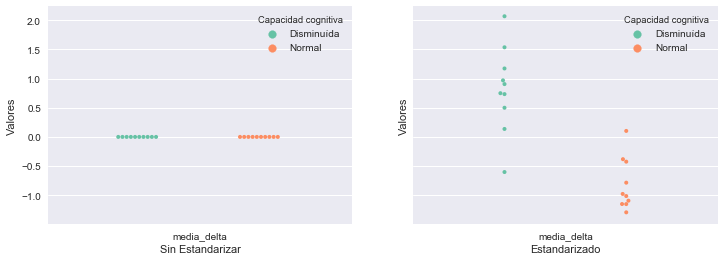

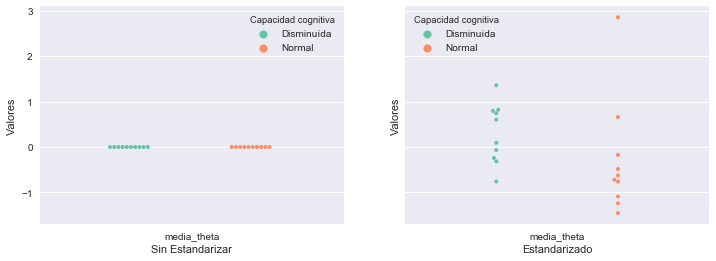

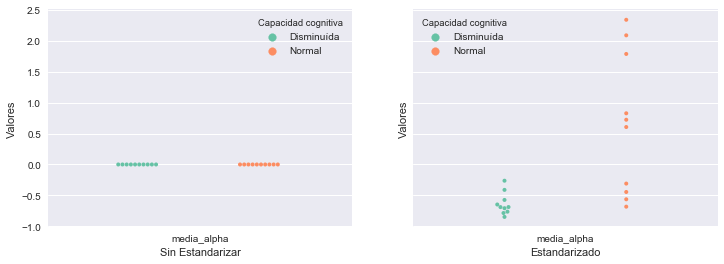

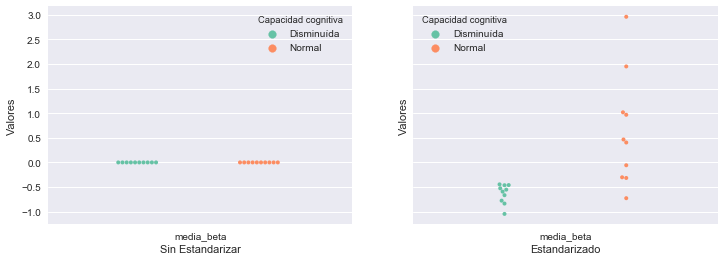

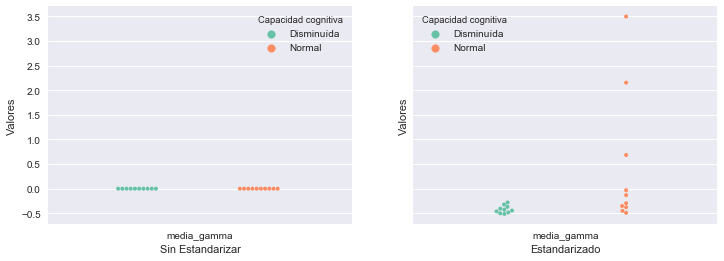

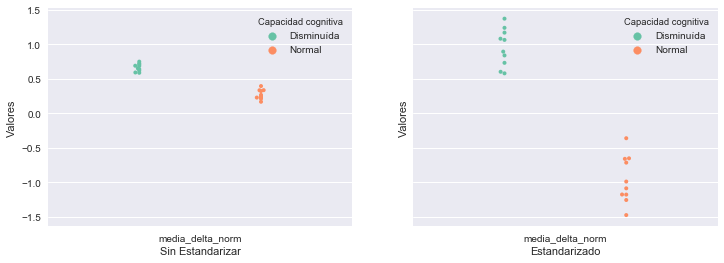

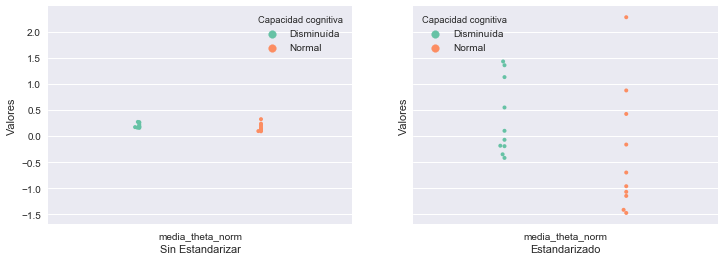

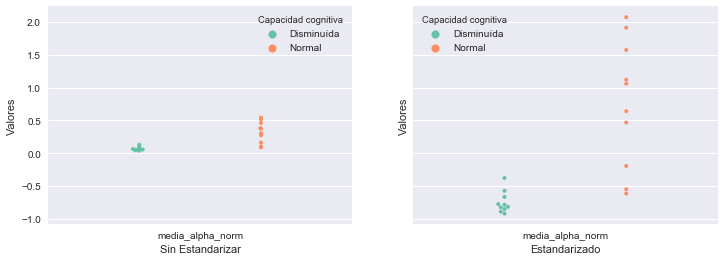

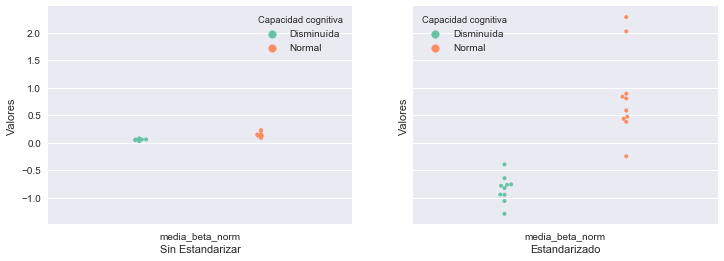

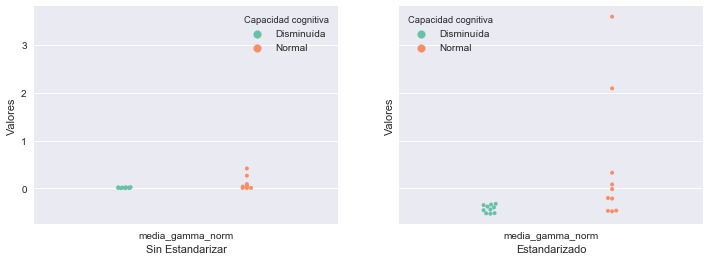

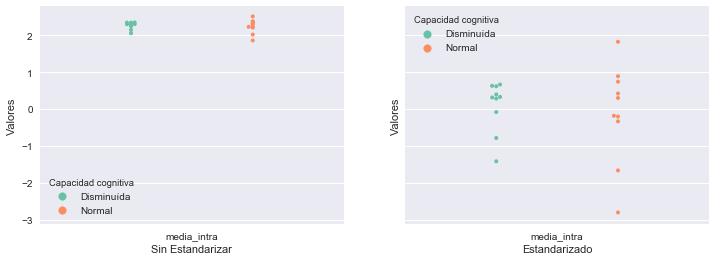

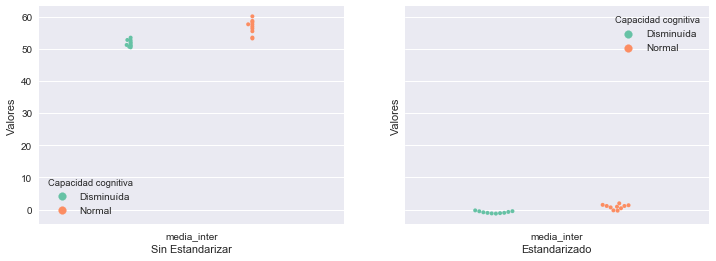

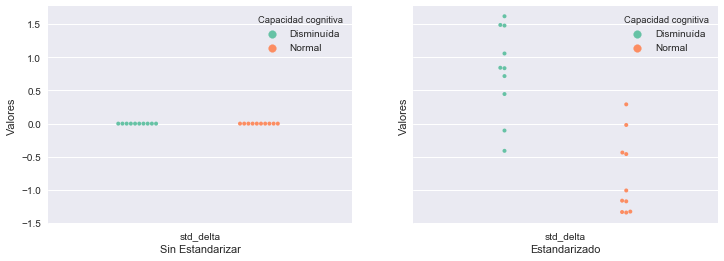

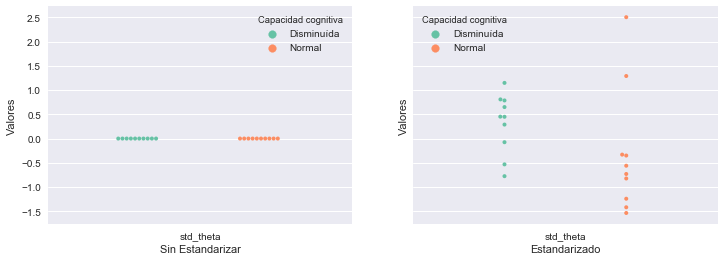

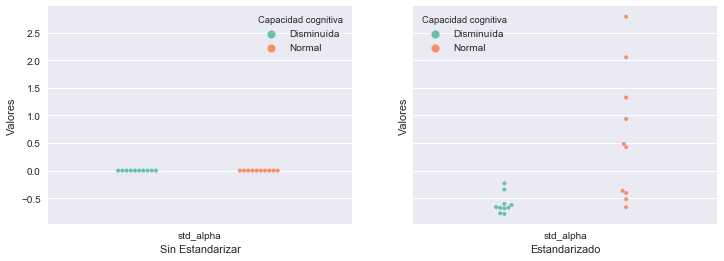

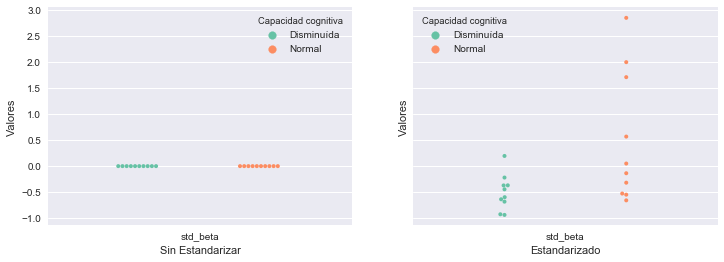

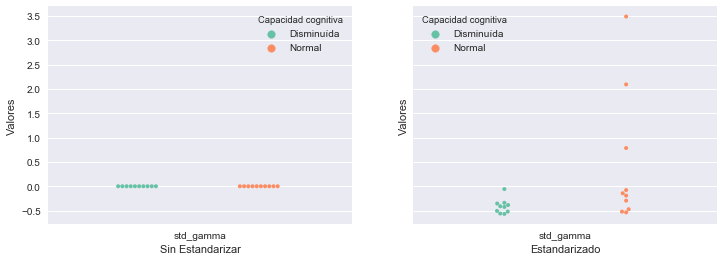

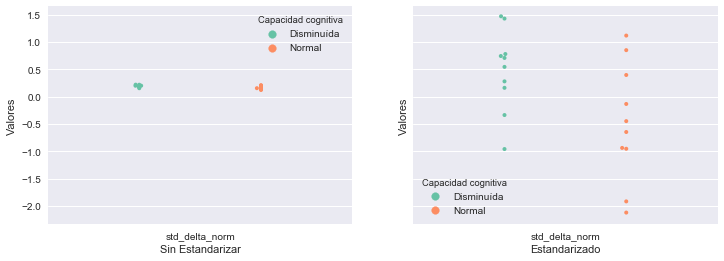

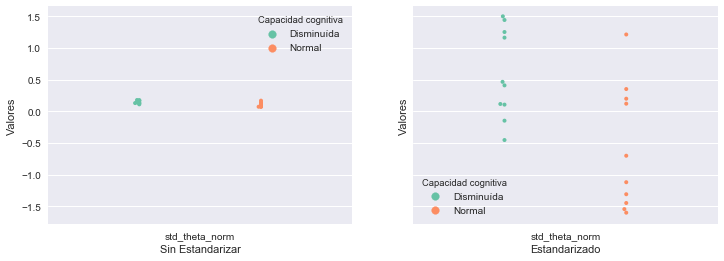

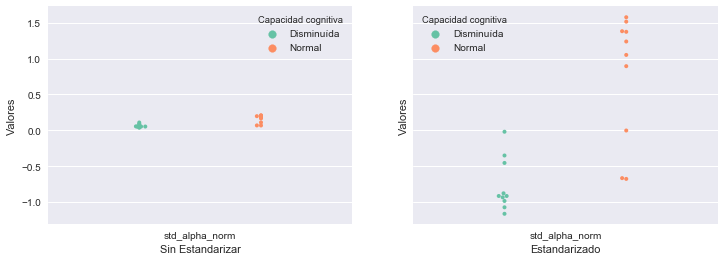

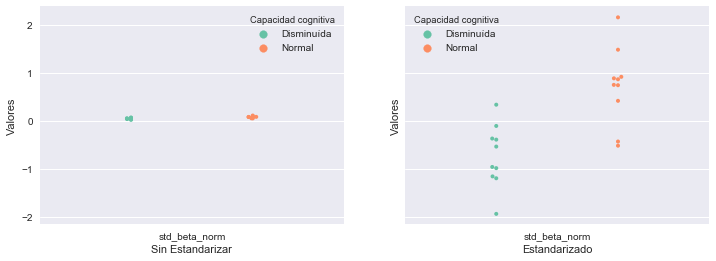

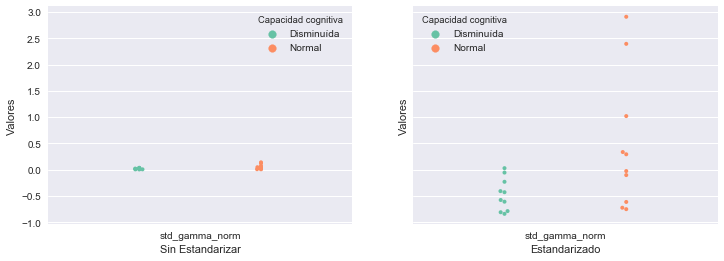

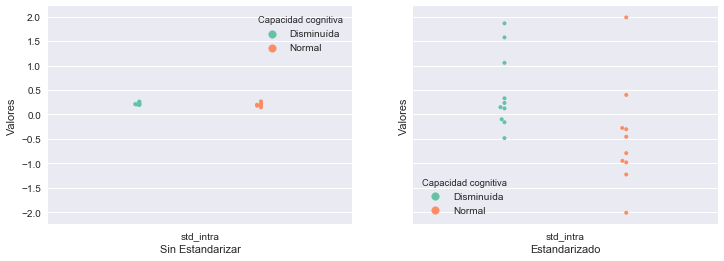

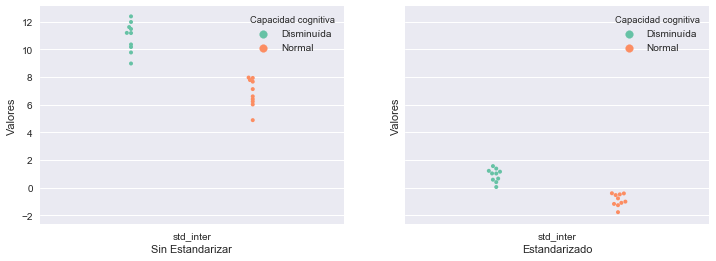

In [17]:
#print (df_features_normalizado_compress)
printear_comparacion_sin_y_con_estandarizar(np_features_por_paciente, np_features_por_paciente_norm, give_expected_ordered_keys())

In [18]:
numpy_to_pickle(np_features_por_paciente_norm, "df_features_estandarizado")

Creando index...
agrupacion_feature       media                                          \
feature                  delta     theta     alpha      beta     gamma   
tipo indice_paciente                                                     
P    0                0.500218 -0.240771 -0.688548 -0.459638 -0.406289   
     1                0.970334  0.601456 -0.762397 -0.775901 -0.369460   
     2                2.070471  0.795315 -0.646674 -0.835162 -0.482753   
     3                0.734391  1.359020 -0.410337 -0.592436 -0.501728   
     4                1.537761  0.742978 -0.572930 -0.462701 -0.280550   
     5                0.906179 -0.067369 -0.262275 -0.525551 -0.513124   
     6                0.750122 -0.314996 -0.784281 -0.665039 -0.321525   
     7               -0.602819 -0.758998 -0.847090 -1.045086 -0.462120   
     8                0.136471  0.820192 -0.706432 -0.552029 -0.445396   
     9                1.174379  0.092469 -0.687654 -0.445428 -0.425332   
S    0               

<blockquote>
<p>Aunque visualmente no lo parezca, el desvío quedó en 1 y la medía más cerca del 0 (aunque no en 0). Algo a tener en cuenta es que estamos estandarizando por <i>feature</i>, y eso incluye tanto a los pacientes P como a los S.  
La apertura de los valores tiene sólo sentido viendo que los valores antes de estandarizar son muy pequeños.</p>
</blockquote>

<h4>Resumen de datos sin estandarizar</h4>

In [22]:
print(np.array([p[0] for p in np_features_por_paciente]))
print("media {}".format(np.mean(np.array([p[0] for p in np_features_por_paciente]))))
print("std {}".format(np.std(np.array([p[0] for p in np_features_por_paciente]))))

[  1.64020028e-11   2.02727252e-11   2.93307575e-11   1.83300729e-11
   2.49446658e-11   1.97445003e-11   1.84595979e-11   7.32008586e-12
   1.34070686e-11   2.19527438e-11   8.78583783e-12   3.27255133e-12
   3.92576050e-12   5.81786189e-12   1.31287042e-11   9.13603954e-12
   1.62439825e-12   2.79926227e-12   2.78941699e-12   4.22452573e-12]
media 1.2283428962309579e-11
std 8.23355239968603e-12


<h4>Resumen de datos estandarizando</h4>

In [24]:
print(np.array([p[0] for p in np_features_por_paciente_norm]))
print("media {}".format(np.mean(np.array([p[0] for p in np_features_por_paciente_norm]))))
print("std {}".format(np.std(np.array([p[0] for p in np_features_por_paciente_norm]))))

[ 0.50021833  0.97033405  2.07047064  0.73439066  1.53776112  0.90617889
  0.75012202 -0.60281916  0.13647082  1.17437947 -0.42479734 -1.09440946
 -1.01507442 -0.78527065  0.10266228 -0.38226385 -1.29458467 -1.15189243
 -1.15308818 -0.97878811]
media -1.27675647831893e-16
std 1.0
